In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import json
import time
import matplotlib.pyplot as plt

from tqdm import tqdm
import scipy.sparse as sp
from scipy.sparse import coo_matrix
import random
import torch
import torch.nn as nn
import os
import glob

%matplotlib inline
sns.set_style("white")

# Data prerpocessing

In [ ]:
train_df = pd.read_parquet("./dataset/filtered_train.parquet")
test_df = pd.read_parquet("./dataset/filtered_test.parquet")

In [ ]:
print(train_df.shape)
print(test_df.shape)

(5376, 4)
(1810, 4)


In [ ]:
num_train_users = train_df['user_id'].nunique()
num_train_items = train_df['parent_asin'].nunique()

num_test_users = test_df['user_id'].nunique()
num_test_items = test_df['parent_asin'].nunique()

print(f"train 사용자 수: {num_train_users}")
print(f"train 상품 수: {num_train_items}")
print(f"test 사용자 수: {num_test_users}")
print(f"test 상품 수: {num_test_items}")

train 사용자 수: 804
train 상품 수: 829
test 사용자 수: 585
test 상품 수: 602


In [ ]:
df = pd.concat([train_df, test_df], axis=0)

n_users, n_items = df['user_id'].nunique(), df['parent_asin'].nunique()

print(f"전체 사용자 수: {n_users}")
print(f"전체 상품 수: {n_items}")

전체 사용자 수: 833
전체 상품 수: 870


In [ ]:
col_user, col_item, col_rating = 'user_id', 'parent_asin', 'rating'

In [ ]:
# user, item id별 고유 인덱스 저장
user_idx = df[[col_user]].drop_duplicates().reset_index(drop=True).reset_index().rename(columns={"index":col_user + "_idx"})
item_idx = df[[col_item]].drop_duplicates().reset_index(drop=True).reset_index().rename(columns={"index":col_item + "_idx"})
user_idx.head()

,user_id_idx,user_id
0,0,0
1,1,1
2,2,2
3,3,3
4,4,4


In [ ]:
user2id = dict( zip(user_idx[col_user], user_idx[col_user + "_idx"]))
id2user = dict( zip(user_idx[col_user + "_idx"], user_idx[col_user]))
item2id = dict( zip(item_idx[col_item], item_idx[col_item + "_idx"]))
id2item = dict( zip(item_idx[col_item + "_idx"], item_idx[col_item]))

In [ ]:
# # user to id & item to id mapping
train_df[col_user] = train_df[col_user].map(user2id)
train_df[col_item] = train_df[col_item].map(item2id)
test_df[col_user] = test_df[col_user].map(user2id)
test_df[col_item] = test_df[col_item].map(item2id)

train_df.head()

,rating,parent_asin,user_id,timestamp
15167400,5.0,0,0,1383365905000
15167388,5.0,1,0,1396612913000
15167579,5.0,2,0,1237129912000
15167361,5.0,3,0,1433018506000
15167193,5.0,4,0,1603133693699


# User-Item Interaction matrix  and Adjacent matrix for **train data**

전체 데이터의 user의 수를 $M$, item의 수를 $N$이라고 하자.User-Item interaction 행렬 $\mathbf{R} \in \mathbb{R}^{M \times N}$의 각 원소는 학습 데이터의 user $i$가 학습데이터의 item $j$ 에 리뷰를 남겼을 경우, $\{\mathbf{R}\}_{ij} \in \mathbb{R}^{M \times N} = 1 $ 이고, 나머지는  $0$이다.

- $M$: The number of unique users in **train-test data**
- $N$: The number of unique items in **train-test data**



**Note.** GCN은 Transductive Learning 계열의 모델임을 유의하자. 즉, test data도 모델에 들어가기에 $\mathbf{R}$에는 모든 데이터셋의 정보를 반영하는 행렬을 넣어주되, interaction의 여부는 학습데이터에 한해서만 채워준다.

In [ ]:
interaction_status = train_df.groupby(col_user)[col_item].apply(set).reset_index().rename(columns={col_item : col_item+"_interacted"})
interaction_status.head()

,user_id,parent_asin_interacted
0,0,"{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}"
1,1,"{5, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}"
2,2,"{24, 23}"
3,3,"{25, 26, 27, 28}"
4,4,"{32, 29, 30, 31}"


- DOK Format: Best for constructing sparse matrices incrementally.
- LIL Format: Best for efficient access, slicing, and conversion to other sparse formats (Linked list, Memory leackage)

In [ ]:
R = sp.dok_matrix((n_users, n_items), dtype=np.float32) # remark. Initialize to train-test dataset
R[train_df[col_user], train_df[col_item]] = 1.0 # store the information about train data
R = R.tolil()  #stored elements in Dictionary Of Keys format -> List of Lists format
R # (The number of unique users) x (The number of unique items)

<833x870 sparse matrix of type '<class 'numpy.float32'>'
	with 5299 stored elements in List of Lists format>

In [ ]:
print(R[:10,:10])

  (0, 0)	1.0
  (0, 1)	1.0
  (0, 2)	1.0
  (0, 3)	1.0
  (0, 4)	1.0
  (0, 5)	1.0
  (0, 6)	1.0
  (0, 7)	1.0
  (0, 8)	1.0
  (0, 9)	1.0
  (1, 5)	1.0


인접 행렬(adjacency matrix)
$\mathbf{A} = \begin{pmatrix} \mathbf{0} & \mathbf{R}\\ \mathbf{R^T} & \mathbf{0} \end{pmatrix} \in \mathbb{R}^{(M+N) \times (M+N)}$

In [ ]:
adj_mat = sp.dok_matrix((n_users+n_items, n_users+n_items), dtype=np.float32)
adj_mat = adj_mat.tolil()
adj_mat[:n_users, n_users:] = R
adj_mat[n_users:, :n_users] = R.T
adj_mat = adj_mat.todok()
adj_mat

<1703x1703 sparse matrix of type '<class 'numpy.float32'>'
	with 10598 stored elements in Dictionary Of Keys format>

정규화된 인접 행렬(normalized adjacency matrix) : $\tilde{\mathbf{A}} =  \mathbf{D}^{-1/2}\mathbf{A}\mathbf{D}^{-1/2} $,  $\mathbf{D}$는 각 대각원소 $d_{ii}$는 $i$번째 행 벡터에서 0이 아닌 원소의 수인 대각 행렬, 즉  $\mathbf{D}= diag(d_{11},....,d_{M+N})$



In [ ]:
rowsum = np.array(adj_mat.sum(1)).flatten() # The number of non-zero entries in i-th row vector
d_inv_sqrt = (rowsum + 1e-9) ** -0.5
d_inv_sqrt[np.isinf(d_inv_sqrt)] = 0.0
d_mat_inv_sqrt = sp.diags(d_inv_sqrt)
d_mat_inv_sqrt

<1703x1703 sparse matrix of type '<class 'numpy.float32'>'
	with 1703 stored elements (1 diagonals) in DIAgonal format>

In [ ]:
norm_adj_mat = d_mat_inv_sqrt.dot(adj_mat)
norm_adj_mat = norm_adj_mat.dot(d_mat_inv_sqrt)
norm_adj_mat

<1703x1703 sparse matrix of type '<class 'numpy.float32'>'
	with 10598 stored elements in Compressed Sparse Row format>

# Data Loader

lightGCN에서 학습 파라미터인 초기 임베딩 벡터의 loss를 구하기 위해 구현한다. interaction_status 데이터프레임을 사용하여, 개별 유저에 대해 interaction이 있는 item sample 쌍은 positive sample, interaction이 없는 아이템 중 임의로 추출한 (user, item) 쌍은 negative sample이라 정의한다.

- positive sample item : sampling from user-item interaction
- negative sample item : random number

In [ ]:
batch_size = 25
users = random.sample(range(num_train_users), batch_size) # batch_size 만큼 비복원 추출

# positive sampling
pos_items = interaction_status.iloc[users,1].apply(lambda x: random.choice(list(x)))
pos_items.head()

,parent_asin_interacted
397,141
36,189
48,233
227,3
650,401


In [ ]:
def sample_neg(x):
    if len(x) >= n_items: # Given user is interaced to all items i.e. All items are positive samples
        raise ValueError("A user has voted in every item. Can't find a negative sample.")
    while True:
        neg_id = random.randint(0, n_items - 1) # choose random number
        if neg_id not in x: # if neg_id is in x, then it is positive sample i.e. sampling again
            return neg_id

# negative sampling
neg_items = interaction_status.iloc[users,1].apply(sample_neg)
neg_items.head()

,parent_asin_interacted
397,194
36,88
48,415
227,256
650,352


In [ ]:
 mini_batch = {"user_idx":np.array(users), "pos_item_idx":np.array(pos_items), "neg_item_idx":np.array(neg_items)} # mini batch input for LightGCN
 mini_batch

{'user_idx': array([397,  36,  48, 227, 650, 265, 672,  63, 648,  69,  38, 442, 169,
        750, 651, 633, 418, 699, 203, 156, 399, 779, 528, 575, 225]),
 'pos_item_idx': array([141, 189, 233,   3, 401,  21,  49, 151, 203, 272, 192, 189, 343,
        102, 367,  78,  39, 249, 320, 102, 322, 248,  29, 697, 293]),
 'neg_item_idx': array([194,  88, 415, 256, 352, 690, 775, 313, 609, 615, 144, 246, 729,
        610, 605,  56, 109, 867, 761, 766, 276, 340, 380, 638, 827])}

In [ ]:
from module.DataLoader import DataLoader

path_dir = {
    "preprocessed_df_path": "./preprocessed_data/",
    "norm_adj_mat_path": "./preprocessed_data/norm_adj_mat.npz",
    "norm_adj_mat_chunk_path": "./preprocessed_data/norm_adj_mat_chunks/"
}

col_name = {"col_user":'user_id', "col_item":'parent_asin', "col_rating" : 'rating'}

data = DataLoader(train_df, test_df, path_dir, col_name)

In [ ]:
data.create_norm_adj_mat()

Normalizing adjacency matrix in chunks...


100%|██████████| 1/1 [00:00<00:00,  1.48it/s]


Combining chunks into the final normalized adjacency matrix...


<1703x1703 sparse matrix of type '<class 'numpy.float64'>'
	with 10598 stored elements in Compressed Sparse Row format>

# LightGCN

## Torch Tensor

`_COO_to_torch_sparse()` method

In [ ]:
norm_adj_mat = data.create_norm_adj_mat(is_exists=True)
norm_adj_mat_coo = norm_adj_mat.tocoo().astype(np.float32) # DOK to COO format (tuple)

indices = np.vstack((norm_adj_mat_coo.row, norm_adj_mat_coo.col))
values = norm_adj_mat_coo.data

print("indices: ", indices)
print("values: ", values)

indices:  [[   0    0    0 ... 1659 1660 1661]
 [ 833  834  835 ...  790  798  799]]
values:  [0.09128709 0.11785113 0.04811252 ... 0.35355338 0.1796053  0.37796447]


In [ ]:
# COO to torch.sparse
i = torch.LongTensor(indices)
v = torch.FloatTensor(values)
shape = norm_adj_mat_coo.shape

norm_adj_mat_sparse_tensor = torch.sparse.FloatTensor(i, v, torch.Size(shape))
print(norm_adj_mat_sparse_tensor.shape)

torch.Size([1703, 1703])


<ipython-input-29-bc1b7e1ca705>:6: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:651.)
  norm_adj_mat_sparse_tensor = torch.sparse.FloatTensor(i, v, torch.Size(shape))


In [ ]:
data.n_items + data.n_users

1703

In [ ]:
hyper_params = {"n_layers":3, "latent_dim":32}

## Light Graph Colvolution

`LighGraphConvolution_operation()` method

### Initalize $\mathbf{E}^{(0)} = [\mathbf{E}_u^{(0)}, \mathbf{E}_i^{(0)}]  \in \mathbb{R}^{(M+N) \times H}$ where $\mathbf{E}_u^{(0)} \in \mathbb{R}^{M \times H}, \mathbf{E}_i^{(0)} \in \mathbb{R}^{N \times H}$ by Xavier Initialization. (See 4.1.2 in LightGCN paper)

- M : the number of users
- N : the number of items
- H : the number of latent variables

In [ ]:
E_0 = nn.Embedding(data.n_users + data.n_items, 32)
nn.init.xavier_uniform_(E_0.weight)
E_0.weight = nn.Parameter(E_0.weight)
E_0.weight

Parameter containing:
tensor([[ 0.0020,  0.0156,  0.0307,  ...,  0.0040,  0.0186,  0.0192],
        [-0.0047, -0.0468, -0.0543,  ..., -0.0017,  0.0030, -0.0396],
        [ 0.0151, -0.0037, -0.0256,  ...,  0.0244,  0.0273,  0.0196],
        ...,
        [-0.0292,  0.0181, -0.0104,  ...,  0.0222, -0.0579, -0.0511],
        [ 0.0236,  0.0270, -0.0483,  ...,  0.0251,  0.0348, -0.0513],
        [ 0.0302,  0.0378,  0.0403,  ...,  0.0414, -0.0431,  0.0434]],
       requires_grad=True)

### LGC operation

In this paper, $\alpha$ is uniform for $1/(K+1)$ i.e. In final step, use mean operation instead weight summation.
- all_layer_embedding: $[\mathbf{E}^{(0)},\mathbf{E}^{(1)}, ..., \mathbf{E}^{(K)} ]$ where $K$ is the number of layers and $\mathbf{E}^{(k)} = \tilde{\mathbf{A}}\mathbf{E}^{(k-1)}$ for $k = 1,...,K$

In [ ]:
all_layer_embedding = [E_0.weight]
E_k = E_0.weight

for k in range(3): # e.g. K=3
  E_k = torch.sparse.mm(norm_adj_mat_sparse_tensor, E_k)
  all_layer_embedding.append(E_k)

all_layer_embedding = torch.stack(all_layer_embedding)
all_layer_embedding.shape

torch.Size([4, 1703, 32])

2. 각 $k = 1,...,K$마다, layer의 임베딩 벡터를 $\mathbf{E}^{(k)} = \tilde{\mathbf{A}}\mathbf{E}^{(k-1)}$를 통해 계산
- all_layer_embedding: $[\mathbf{E}^{(0)},\mathbf{E}^{(1)}, ..., \mathbf{E}^{(K)} ]$ where $K$ is the number of layers and $\mathbf{E}^{(k)} = \tilde{\mathbf{A}}\mathbf{E}^{(k-1)}$ for $k = 1,...,K$



The form of final representation(See 3.1.2 in LightGCN paper)

- $\mathbf{e}_u = \sum_{k=0}^K \alpha_k \mathbf{e}_u^{(k)} = \frac{1}{K+1} \sum_{k=0}^K  \mathbf{e}_u^{(k)} = ave(\{\mathbf{e}_u^{(k)}\}_{k=0}^{K})$
- $\mathbf{e}_i = \sum_{k=0}^K \alpha_k \mathbf{e}_i^{(k)} = \frac{1}{K+1} \sum_{k=0}^K  \mathbf{e}_i^{(k)} = ave(\{\mathbf{e}_i^{(k)}\}_{k=0}^{K})$


**[Step]**
1. Average the all_layer_embedding on each layer
2. Split to User Embedding and Item Embedding

In [ ]:
mean_layer_embedding = torch.mean(all_layer_embedding, axis = 0)
final_user_Embed, final_item_Embed = torch.split(mean_layer_embedding, [n_users, n_items])
print(final_user_Embed.shape)
print(final_item_Embed.shape)

torch.Size([833, 32])
torch.Size([870, 32])


## BPR Loss

#### $L_{BPR} = \sum_{u=1}^M \sum_{i \in N_u} \left( \sum_{j \notin N_u} \ln\sigma(\hat{y}_{ui} - \hat{y}_{uj})\right) + \lambda \|\mathbf{E}_0\|^2$


- $\hat{y}_{ui} = \mathbf{e}_u^T\mathbf{e}_i$ : positive sample for user $u$ (훈련 데이터에서 실제 리뷰가 있는 아이템 대상)
- $\hat{y}_{uj}$ : negative sample for user $u$ (유저가 리뷰하지 않은 아이템 중에 랜덤으로 샘플링)
- $\sigma(\cdot)$ : softmax function


Setting `BATCH_SIZE`.


In each iteration,

```{python}
users, pos_items, neg_items = data.train_loader(BATCH_SIZE)
users_emb, pos_emb, neg_emb, userEmb0,  posEmb0, negEmb0 = lightGCN.forward(users, pos_items, neg_items)

mf_loss, reg_loss = bpr_loss(users, users_emb, pos_emb, neg_emb, userEmb0,  posEmb0, negEmb0)
reg_loss = DECAY * reg_loss
final_loss = mf_loss + reg_loss
```

In [ ]:
def bpr_loss(users, users_emb, pos_emb, neg_emb, userEmb0,  posEmb0, negEmb0):
    pos_scores = torch.mul(users_emb, pos_emb)
    pos_scores = torch.sum(pos_scores, dim=1)
    neg_scores = torch.mul(users_emb, neg_emb)
    neg_scores = torch.sum(neg_scores, dim=1)

    loss = torch.mean(torch.nn.functional.softplus(neg_scores - pos_scores))

    reg_loss = (1/2)*(userEmb0.norm().pow(2) + posEmb0.norm().pow(2)  + negEmb0.norm().pow(2))/float(len(users)) # L2 norm

    return loss, reg_loss

## Hyper parameter setting

We optimize LightGCN with Adam [22] and use the default learning rate of 0.001 and default mini-batch size of 1024 (on Amazon-Book, we increase the mini-
batch size to 2048 for speed). The $L_2$ regularization coefficient λ is $1e^{-4}$.We test $K$ in the range of 1 to 4, and satisfactory performance can be achieved when $K$ equals to $3$. The early stopping and validation strategies are the same as NGCF. Typically, $1000$ epochs are sufficient for LightGCN to converge.



## Model Training

In [ ]:
from module.LightGCN import LightGCN, bpr_loss

hyper_params = {"n_layers":3, "latent_dim":64}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

lightGCN = LightGCN(data, hyper_params, device = device)
optimizer = torch.optim.Adam(lightGCN.parameters(), lr = 0.005)

Normalizing adjacency matrix in chunks...


100%|██████████| 1/1 [00:00<00:00, 39.24it/s]

Combining chunks into the final normalized adjacency matrix...



/content/drive/MyDrive/CS/BOAZ_rec/module/LightGCN.py:39: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:651.)
  return torch.sparse.FloatTensor(i, v, torch.Size(shape))


In [ ]:
EPOCHS = 100
BATCH_SIZE = 128 # 2048 in this paper
DECAY = 0.0001
K = 3

In [ ]:
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
# os.kill(os.getpid(), 9)

In [ ]:
!nvidia-smi

Thu Dec 12 08:56:37 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
torch.cuda.empty_cache()

In [ ]:
# Training setup
loss_list_epoch = []
MF_loss_list_epoch = []
reg_loss_list_epoch = []

train_time_list = []

for epoch in tqdm(range(EPOCHS), desc="Training Epochs"):
    n_batch = len(train_df) // BATCH_SIZE

    final_loss_list = []
    MF_loss_list = []
    reg_loss_list = []

    best_ndcg = -1

    train_start_time = time.time()
    lightGCN.train()

    for batch_idx in range(n_batch):
      optimizer.zero_grad()

      users, pos_items, neg_items = data.train_loader(BATCH_SIZE)
      users = torch.tensor(users, dtype=torch.long, device=device)
      pos_items = torch.tensor(pos_items, dtype=torch.long, device=device)
      neg_items = torch.tensor(neg_items, dtype=torch.long, device=device)

      users_emb, pos_emb, neg_emb, userEmb0, posEmb0, negEmb0 = lightGCN.forward(users, pos_items, neg_items)

      mf_loss, reg_loss = bpr_loss(users, users_emb, pos_emb, neg_emb, userEmb0,  posEmb0, negEmb0)
      reg_loss = DECAY * reg_loss
      final_loss = mf_loss + reg_loss


      final_loss.backward()
      optimizer.step()

      final_loss_list.append(final_loss.item())
      MF_loss_list.append(mf_loss.item())
      reg_loss_list.append(reg_loss.item())

    train_end_time = time.time()
    train_time = train_end_time - train_start_time

    loss_list_epoch.append(round(np.mean(final_loss_list), 4))
    MF_loss_list_epoch.append(round(np.mean(MF_loss_list), 4))
    reg_loss_list_epoch.append(round(np.mean(reg_loss_list), 4))
    print(f"Loss in in epoch {epoch+1}:  {round(np.mean(final_loss_list), 4)}.")

Training Epochs:   1%|          | 1/100 [00:01<03:17,  2.00s/it]

Loss in in epoch 1:  0.6421.


Training Epochs:   2%|▏         | 2/100 [00:02<01:37,  1.00it/s]

Loss in in epoch 2:  0.3819.


Training Epochs:   3%|▎         | 3/100 [00:02<01:04,  1.50it/s]

Loss in in epoch 3:  0.2465.


Training Epochs:   4%|▍         | 4/100 [00:02<00:49,  1.96it/s]

Loss in in epoch 4:  0.194.


Training Epochs:   5%|▌         | 5/100 [00:03<00:40,  2.37it/s]

Loss in in epoch 5:  0.1501.


Training Epochs:   6%|▌         | 6/100 [00:03<00:34,  2.71it/s]

Loss in in epoch 6:  0.1236.


Training Epochs:   7%|▋         | 7/100 [00:03<00:30,  3.01it/s]

Loss in in epoch 7:  0.1076.


Training Epochs:   8%|▊         | 8/100 [00:03<00:28,  3.21it/s]

Loss in in epoch 8:  0.0983.


Training Epochs:   9%|▉         | 9/100 [00:04<00:27,  3.35it/s]

Loss in in epoch 9:  0.0864.


Training Epochs:  10%|█         | 10/100 [00:04<00:26,  3.45it/s]

Loss in in epoch 10:  0.0752.


Training Epochs:  11%|█         | 11/100 [00:04<00:25,  3.53it/s]

Loss in in epoch 11:  0.0656.


Training Epochs:  12%|█▏        | 12/100 [00:04<00:24,  3.59it/s]

Loss in in epoch 12:  0.06.


Training Epochs:  13%|█▎        | 13/100 [00:05<00:23,  3.63it/s]

Loss in in epoch 13:  0.0572.


Training Epochs:  14%|█▍        | 14/100 [00:05<00:23,  3.68it/s]

Loss in in epoch 14:  0.0507.


Training Epochs:  15%|█▌        | 15/100 [00:05<00:22,  3.74it/s]

Loss in in epoch 15:  0.046.


Training Epochs:  16%|█▌        | 16/100 [00:06<00:22,  3.75it/s]

Loss in in epoch 16:  0.049.


Training Epochs:  17%|█▋        | 17/100 [00:06<00:22,  3.72it/s]

Loss in in epoch 17:  0.0448.


Training Epochs:  18%|█▊        | 18/100 [00:06<00:21,  3.74it/s]

Loss in in epoch 18:  0.0394.


Training Epochs:  19%|█▉        | 19/100 [00:06<00:21,  3.74it/s]

Loss in in epoch 19:  0.0383.


Training Epochs:  20%|██        | 20/100 [00:07<00:21,  3.71it/s]

Loss in in epoch 20:  0.0357.


Training Epochs:  21%|██        | 21/100 [00:07<00:21,  3.70it/s]

Loss in in epoch 21:  0.0309.


Training Epochs:  22%|██▏       | 22/100 [00:07<00:21,  3.71it/s]

Loss in in epoch 22:  0.0295.


Training Epochs:  23%|██▎       | 23/100 [00:07<00:20,  3.71it/s]

Loss in in epoch 23:  0.029.


Training Epochs:  24%|██▍       | 24/100 [00:08<00:20,  3.78it/s]

Loss in in epoch 24:  0.0256.


Training Epochs:  25%|██▌       | 25/100 [00:08<00:19,  3.80it/s]

Loss in in epoch 25:  0.0249.


Training Epochs:  26%|██▌       | 26/100 [00:08<00:19,  3.83it/s]

Loss in in epoch 26:  0.0248.


Training Epochs:  27%|██▋       | 27/100 [00:08<00:18,  3.86it/s]

Loss in in epoch 27:  0.0267.


Training Epochs:  28%|██▊       | 28/100 [00:09<00:18,  3.87it/s]

Loss in in epoch 28:  0.026.


Training Epochs:  29%|██▉       | 29/100 [00:09<00:18,  3.86it/s]

Loss in in epoch 29:  0.0228.


Training Epochs:  30%|███       | 30/100 [00:09<00:18,  3.86it/s]

Loss in in epoch 30:  0.0249.


Training Epochs:  31%|███       | 31/100 [00:09<00:17,  3.86it/s]

Loss in in epoch 31:  0.0246.


Training Epochs:  32%|███▏      | 32/100 [00:10<00:17,  3.86it/s]

Loss in in epoch 32:  0.0191.


Training Epochs:  33%|███▎      | 33/100 [00:10<00:17,  3.86it/s]

Loss in in epoch 33:  0.0208.


Training Epochs:  34%|███▍      | 34/100 [00:10<00:17,  3.81it/s]

Loss in in epoch 34:  0.0186.


Training Epochs:  35%|███▌      | 35/100 [00:11<00:17,  3.80it/s]

Loss in in epoch 35:  0.0185.


Training Epochs:  36%|███▌      | 36/100 [00:11<00:16,  3.79it/s]

Loss in in epoch 36:  0.017.


Training Epochs:  37%|███▋      | 37/100 [00:11<00:16,  3.80it/s]

Loss in in epoch 37:  0.0164.


Training Epochs:  38%|███▊      | 38/100 [00:11<00:16,  3.81it/s]

Loss in in epoch 38:  0.0202.


Training Epochs:  39%|███▉      | 39/100 [00:12<00:16,  3.80it/s]

Loss in in epoch 39:  0.0174.


Training Epochs:  40%|████      | 40/100 [00:12<00:15,  3.76it/s]

Loss in in epoch 40:  0.0157.


Training Epochs:  41%|████      | 41/100 [00:12<00:15,  3.72it/s]

Loss in in epoch 41:  0.0168.


Training Epochs:  42%|████▏     | 42/100 [00:12<00:15,  3.73it/s]

Loss in in epoch 42:  0.0165.


Training Epochs:  43%|████▎     | 43/100 [00:13<00:15,  3.69it/s]

Loss in in epoch 43:  0.0168.


Training Epochs:  44%|████▍     | 44/100 [00:13<00:15,  3.70it/s]

Loss in in epoch 44:  0.0167.


Training Epochs:  45%|████▌     | 45/100 [00:13<00:14,  3.71it/s]

Loss in in epoch 45:  0.014.


Training Epochs:  46%|████▌     | 46/100 [00:13<00:14,  3.69it/s]

Loss in in epoch 46:  0.0136.


Training Epochs:  47%|████▋     | 47/100 [00:14<00:14,  3.66it/s]

Loss in in epoch 47:  0.0148.


Training Epochs:  48%|████▊     | 48/100 [00:14<00:14,  3.57it/s]

Loss in in epoch 48:  0.0131.


Training Epochs:  49%|████▉     | 49/100 [00:14<00:14,  3.61it/s]

Loss in in epoch 49:  0.012.


Training Epochs:  50%|█████     | 50/100 [00:15<00:13,  3.65it/s]

Loss in in epoch 50:  0.0138.


Training Epochs:  51%|█████     | 51/100 [00:15<00:13,  3.68it/s]

Loss in in epoch 51:  0.0132.


Training Epochs:  52%|█████▏    | 52/100 [00:15<00:12,  3.71it/s]

Loss in in epoch 52:  0.0119.


Training Epochs:  53%|█████▎    | 53/100 [00:15<00:12,  3.76it/s]

Loss in in epoch 53:  0.0134.


Training Epochs:  54%|█████▍    | 54/100 [00:16<00:12,  3.76it/s]

Loss in in epoch 54:  0.0112.


Training Epochs:  55%|█████▌    | 55/100 [00:16<00:11,  3.76it/s]

Loss in in epoch 55:  0.011.


Training Epochs:  56%|█████▌    | 56/100 [00:16<00:11,  3.78it/s]

Loss in in epoch 56:  0.0129.


Training Epochs:  57%|█████▋    | 57/100 [00:16<00:11,  3.80it/s]

Loss in in epoch 57:  0.0109.


Training Epochs:  58%|█████▊    | 58/100 [00:17<00:11,  3.78it/s]

Loss in in epoch 58:  0.0116.


Training Epochs:  59%|█████▉    | 59/100 [00:17<00:10,  3.79it/s]

Loss in in epoch 59:  0.0131.


Training Epochs:  60%|██████    | 60/100 [00:17<00:10,  3.81it/s]

Loss in in epoch 60:  0.0104.


Training Epochs:  61%|██████    | 61/100 [00:17<00:10,  3.81it/s]

Loss in in epoch 61:  0.0106.


Training Epochs:  62%|██████▏   | 62/100 [00:18<00:09,  3.81it/s]

Loss in in epoch 62:  0.011.


Training Epochs:  63%|██████▎   | 63/100 [00:18<00:09,  3.83it/s]

Loss in in epoch 63:  0.0101.


Training Epochs:  64%|██████▍   | 64/100 [00:18<00:09,  3.82it/s]

Loss in in epoch 64:  0.0111.


Training Epochs:  65%|██████▌   | 65/100 [00:19<00:09,  3.81it/s]

Loss in in epoch 65:  0.01.


Training Epochs:  66%|██████▌   | 66/100 [00:19<00:09,  3.77it/s]

Loss in in epoch 66:  0.0094.


Training Epochs:  67%|██████▋   | 67/100 [00:19<00:08,  3.80it/s]

Loss in in epoch 67:  0.0101.


Training Epochs:  68%|██████▊   | 68/100 [00:19<00:08,  3.82it/s]

Loss in in epoch 68:  0.01.


Training Epochs:  69%|██████▉   | 69/100 [00:20<00:08,  3.84it/s]

Loss in in epoch 69:  0.009.


Training Epochs:  70%|███████   | 70/100 [00:20<00:07,  3.83it/s]

Loss in in epoch 70:  0.0108.


Training Epochs:  71%|███████   | 71/100 [00:20<00:07,  3.84it/s]

Loss in in epoch 71:  0.0091.


Training Epochs:  72%|███████▏  | 72/100 [00:20<00:07,  3.83it/s]

Loss in in epoch 72:  0.0098.


Training Epochs:  73%|███████▎  | 73/100 [00:21<00:07,  3.84it/s]

Loss in in epoch 73:  0.0106.


Training Epochs:  74%|███████▍  | 74/100 [00:21<00:06,  3.82it/s]

Loss in in epoch 74:  0.0088.


Training Epochs:  75%|███████▌  | 75/100 [00:21<00:06,  3.81it/s]

Loss in in epoch 75:  0.01.


Training Epochs:  76%|███████▌  | 76/100 [00:21<00:06,  3.82it/s]

Loss in in epoch 76:  0.0086.


Training Epochs:  77%|███████▋  | 77/100 [00:22<00:06,  3.80it/s]

Loss in in epoch 77:  0.0101.


Training Epochs:  78%|███████▊  | 78/100 [00:22<00:05,  3.77it/s]

Loss in in epoch 78:  0.0094.


Training Epochs:  79%|███████▉  | 79/100 [00:22<00:05,  3.77it/s]

Loss in in epoch 79:  0.0082.


Training Epochs:  80%|████████  | 80/100 [00:22<00:05,  3.77it/s]

Loss in in epoch 80:  0.0088.


Training Epochs:  81%|████████  | 81/100 [00:23<00:05,  3.74it/s]

Loss in in epoch 81:  0.0096.


Training Epochs:  82%|████████▏ | 82/100 [00:23<00:04,  3.73it/s]

Loss in in epoch 82:  0.0085.


Training Epochs:  83%|████████▎ | 83/100 [00:23<00:04,  3.67it/s]

Loss in in epoch 83:  0.0087.


Training Epochs:  84%|████████▍ | 84/100 [00:24<00:04,  3.66it/s]

Loss in in epoch 84:  0.0091.


Training Epochs:  85%|████████▌ | 85/100 [00:24<00:04,  3.69it/s]

Loss in in epoch 85:  0.0084.


Training Epochs:  86%|████████▌ | 86/100 [00:24<00:03,  3.70it/s]

Loss in in epoch 86:  0.0079.


Training Epochs:  87%|████████▋ | 87/100 [00:24<00:03,  3.70it/s]

Loss in in epoch 87:  0.0085.


Training Epochs:  88%|████████▊ | 88/100 [00:25<00:03,  3.69it/s]

Loss in in epoch 88:  0.0082.


Training Epochs:  89%|████████▉ | 89/100 [00:25<00:02,  3.67it/s]

Loss in in epoch 89:  0.0079.


Training Epochs:  90%|█████████ | 90/100 [00:25<00:02,  3.69it/s]

Loss in in epoch 90:  0.0082.


Training Epochs:  91%|█████████ | 91/100 [00:25<00:02,  3.72it/s]

Loss in in epoch 91:  0.0085.


Training Epochs:  92%|█████████▏| 92/100 [00:26<00:02,  3.69it/s]

Loss in in epoch 92:  0.0083.


Training Epochs:  93%|█████████▎| 93/100 [00:26<00:01,  3.70it/s]

Loss in in epoch 93:  0.0082.


Training Epochs:  94%|█████████▍| 94/100 [00:26<00:01,  3.64it/s]

Loss in in epoch 94:  0.0081.


Training Epochs:  95%|█████████▌| 95/100 [00:27<00:01,  3.65it/s]

Loss in in epoch 95:  0.0082.


Training Epochs:  96%|█████████▌| 96/100 [00:27<00:01,  3.64it/s]

Loss in in epoch 96:  0.0079.


Training Epochs:  97%|█████████▋| 97/100 [00:27<00:00,  3.68it/s]

Loss in in epoch 97:  0.0072.


Training Epochs:  98%|█████████▊| 98/100 [00:27<00:00,  3.71it/s]

Loss in in epoch 98:  0.0078.


Training Epochs:  99%|█████████▉| 99/100 [00:28<00:00,  3.69it/s]

Loss in in epoch 99:  0.0077.


Training Epochs: 100%|██████████| 100/100 [00:28<00:00,  3.52it/s]

Loss in in epoch 100:  0.0078.


In [ ]:
model_dir = path_dir["preprocessed_df_path"] + "model/"
os.makedirs(model_dir, exist_ok=True)

# Save the model and optimizer state after 100 epochs
torch.save({
    'epoch': epoch,
    'model_state_dict': lightGCN.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss_list_epoch[-1],  # Save the last recorded loss for reference
}, model_dir+'lightGCN_checkpoint.pt')

In [ ]:
model_dir = path_dir["preprocessed_df_path"] + "model/"

checkpoint = torch.load(model_dir+'lightGCN_checkpoint.pt', map_location= device)
lightGCN.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

<ipython-input-16-f4c21d7ab84a>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_dir+'lightGCN_checkpoint.pt', map_location= device)


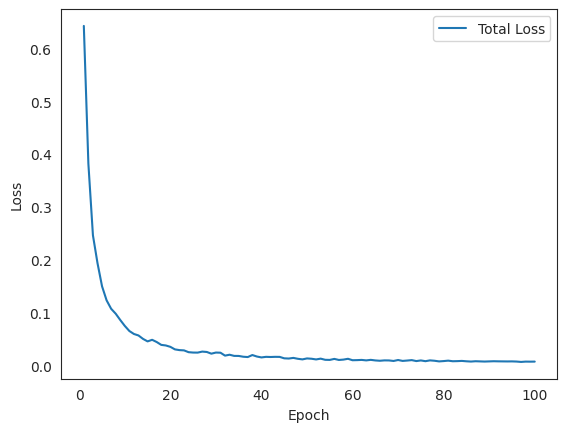

In [ ]:
epoch_list = [(i+1) for i in range(EPOCHS)]

plt.plot(epoch_list, loss_list_epoch, label = "Total Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Evaluation Metrics

In [ ]:
def convert_to_sparse_tensor(dok_mtrx):

    dok_mtrx_coo = dok_mtrx.tocoo().astype(np.float32)
    values = dok_mtrx_coo.data
    indices = np.vstack((dok_mtrx_coo.row, dok_mtrx_coo.col))

    i = torch.LongTensor(indices)
    v = torch.FloatTensor(values)
    shape = dok_mtrx_coo.shape

    dok_mtrx_sparse_tensor = torch.sparse.FloatTensor(i, v, torch.Size(shape))

    return dok_mtrx_sparse_tensor

In [ ]:
with torch.no_grad():
  final_user_Embed, final_item_Embed, _,_ = lightGCN.LightGraphConvolution_operation()

In [ ]:
user_Embedding = nn.Embedding(final_user_Embed.size()[0], final_user_Embed.size()[1], _weight = final_user_Embed)
item_Embedding = nn.Embedding(final_item_Embed.size()[0], final_item_Embed.size()[1], _weight = final_item_Embed)

R = sp.dok_matrix((data.n_users, data.n_items), dtype=np.float32)
R[data.train_df[col_name['col_user']], data.train_df[col_name['col_item']]] = 1.0
R = convert_to_sparse_tensor(R)
R

tensor(indices=tensor([[  0,   0,   0,  ..., 801, 802, 803],
                       [  0,   1,   2,  ..., 790,  15, 259]]),
       values=tensor([1., 1., 1.,  ..., 1., 1., 1.]),
       size=(833, 870), nnz=5299, layout=torch.sparse_coo)

In [ ]:
R_dense = R_dense.to_dense()
R_dense = R_dense*(-np.inf)
R_dense = torch.nan_to_num(R_dense, nan=0.0) # interaction이 있으면 -np.inf, 없으면 0

In [ ]:
# 개별 user에 대해 이미 train set에서 연관이 있는 item은 나오지 않도록, -np.inf만큼 더해줌
relevance_score = torch.matmul(user_Embedding.weight, torch.transpose(item_Embedding.weight, 0, 1)) + R_dense.to(device)
val, idx = torch.sort(relevance_score, descending=True) # 각 row(유저) 별로 내림차순 정렬 및 값, 해당되는 column(아이템) 값 출력; 실제 interaction 이 있는 항은 -np.inf를 통해 뽑히지 않도록 처리

K = 3
# 각 유저마다 대응하는 prediction score가 높은 3개의 아이템 저장
top_k_relevance_scores = val[:,:K]
top_k_relevance_indicies = idx[:,:K]

In [ ]:
top_k_relevance_indicies_df = pd.DataFrame(top_k_relevance_indicies.cpu().numpy(),columns =['top_indx_'+str(x+1) for x in range(K)])
top_k_relevance_indicies_df[col_name['col_user']] = top_k_relevance_indicies_df.index
top_k_relevance_indicies_df['top_relevent_item'] = top_k_relevance_indicies_df[['top_indx_'+str(x+1) for x in range(K)]].values.tolist()
top_k_relevance_indicies_df = top_k_relevance_indicies_df[[col_name['col_user'],'top_relevent_item']]

top_k_relevance_indicies_df.head()

,user_id,top_relevent_item
0,0,"[512, 236, 40]"
1,1,"[45, 85, 139]"
2,2,"[116, 115, 17]"
3,3,"[81, 44, 151]"
4,4,"[454, 290, 301]"


In [ ]:
test_interactions = test_df.groupby(col_name["col_user"])[col_name["col_item"]].apply(list).reset_index()
test_interactions.head() # true label

,user_id,parent_asin
0,0,[614]
1,1,"[234, 139, 57, 438, 110, 82, 85, 89, 293, 24]"
2,2,"[115, 241]"
3,4,"[217, 290, 663]"
4,6,"[117, 15, 563]"


In [ ]:
def get_item_hit(row):
  return list(set(row[col_name['col_item']]).intersection(row['top_relevent_item']))

def get_recall(row):
  item_hit = get_item_hit(row)
  return len(item_hit)/len(row[col_name['col_item']])

def get_precision(row, K = K):
  item_hit = get_item_hit(row)
  return len(item_hit)/K

def get_hit_list(row):
  return [1 if x in set(row[col_name['col_item']]) else 0 for x in row['top_relevent_item']]

def get_dcg_idcg(row):
  hit_list = get_hit_list(row)
  idcg  = sum([1 / np.log1p(idx+1) for idx in range(min(len(row[col_name['col_item']]),len(hit_list)))])
  dcg =  sum([hit / np.log1p(idx+1) for idx, hit in enumerate(hit_list)])
  return dcg / idcg

def get_map(row):
    item_id_idx = row[col_name['col_item']]
    hit_list = get_hit_list(row)
    hit_list_cumsum = np.cumsum(hit_list)

    return sum([hit_cumsum*hit/(idx+1) for idx, (hit, hit_cumsum) in enumerate(zip(hit_list, hit_list_cumsum))])/len(item_id_idx)

In [ ]:
metrics_df = pd.merge(test_interactions,top_k_relevance_indicies_df, how= 'left', on = col_name['col_user'])

metrics_df['recall'] = metrics_df.apply(lambda x : get_recall(x), axis = 1)
metrics_df['precision'] = metrics_df.apply(lambda x : get_precision(x), axis = 1)
metrics_df['ndcg'] = metrics_df.apply(lambda x : get_dcg_idcg(x), axis = 1)
metrics_df['map'] = metrics_df.apply(lambda x : get_map(x), axis = 1)

metrics_df.head()

,user_id,parent_asin,top_relevent_item,recall,precision,ndcg,map
0,0,[614],"[512, 236, 40]",0.000000,0.000000,0.000000,0.000000
1,1,"[234, 139, 57, 438, 110, 82, 85, 89, 293, 24]","[45, 85, 139]",0.200000,0.666667,0.530721,0.116667
2,2,"[115, 241]","[116, 115, 17]",0.500000,0.333333,0.386853,0.250000
3,4,"[217, 290, 663]","[454, 290, 301]",0.333333,0.333333,0.296082,0.166667
4,6,"[117, 15, 563]","[96, 57, 90]",0.000000,0.000000,0.000000,0.000000


In [ ]:
print(np.mean(metrics_df['recall']))
print(np.mean(metrics_df['precision']))
print(np.mean(metrics_df['ndcg']))
print(np.mean(metrics_df['map']))

0.07650547695419489
0.06894586894586893
0.09154553840759845
0.05716017600632985


### Memory Efficiency. chunk단위로 연산

In [ ]:
def get_metrics_with_chunks(topk_relevance_indices, start, test_interactions, K):
  top_k_relevance_indicies_df = pd.DataFrame(topk_relevance_indices.cpu().numpy(),columns =['top_indx_'+str(x+1) for x in range(K)])
  top_k_relevance_indicies_df[col_name['col_user']] = top_k_relevance_indicies_df.index + start

  top_k_relevance_indicies_df['top_relevent_item'] = top_k_relevance_indicies_df[['top_indx_'+str(x+1) for x in range(K)]].values.tolist()
  top_k_relevance_indicies_df = top_k_relevance_indicies_df[[col_name['col_user'],'top_relevent_item']]

  metrics_df = pd.merge(test_interactions,top_k_relevance_indicies_df, how= 'inner', on = col_name['col_user'])

  metrics_df['recall'] = metrics_df.apply(lambda x : get_recall(x), axis = 1)
  metrics_df['precision'] = metrics_df.apply(lambda x : get_precision(x), axis = 1)
  metrics_df['ndcg'] = metrics_df.apply(lambda x : get_dcg_idcg(x), axis = 1)
  metrics_df['map'] = metrics_df.apply(lambda x : get_map(x), axis = 1)

  return metrics_df['recall'].mean(), metrics_df['precision'].mean(), metrics_df['ndcg'].mean(), metrics_df['map'].mean()

In [ ]:
topk_recalls, topk_precisions, topk_ndcgs, topk_maps = [], [], [], []
test_interaction = test_df.groupby(col_name["col_user"])[col_name["col_item"]].apply(list).reset_index()

for start in tqdm(range(0, n_users, batch_size),desc ="Get relevance score"):
    end = min(start + batch_size, n_users)
    user_batch = final_user_Embed[start:end]  # Shape: (batch_size, embedding_dim)
    batch_relevance = torch.matmul(user_batch, (item_Embedding.weight).T)

    # Compute relevance score for the current batch
    batch_relevance = torch.matmul(user_batch, (item_Embedding.weight).T) # Shape: (batch_size, n_items)

    # Assuming R_tensor is a sparse tensor (Sparse COO format)
    batch_mask = torch.zeros((end - start, n_items), dtype=torch.float32)

    # Extract indices and values for the relevant batch
    indices = R.indices()
    values = R.values()

    batch_indices = (indices[0] >= start) & (indices[0] < end)
    filtered_indices = indices[:, batch_indices]
    filtered_indices[0] -= start
    filtered_values = values[batch_indices] * (-np.inf)
    batch_mask.index_put_(tuple(filtered_indices), filtered_values)

    batch_relevance = torch.matmul(user_batch, final_item_Embed.T) # Shape: (batch_size, n_items)
    batch_relevance += batch_mask
    batch_relevance = torch.nan_to_num(batch_relevance, nan=0.0)

    _, indices = torch.sort(batch_relevance, descending=True)
    topk_indicies = indices[:, :K]

    _recall, _precision, _ndcg, _map = get_metrics_with_chunks(topk_indicies, start, test_interaction, K)

    topk_recalls.append(_recall)
    topk_precisions.append(_precision)
    topk_ndcgs.append(_ndcg)
    topk_maps.append(_map)

print('\n')
print(np.mean(topk_recalls))
print(np.mean(topk_precisions))
print(np.mean(topk_ndcgs))
print(np.mean(topk_maps))

Get relevance score: 100%|██████████| 34/34 [00:00<00:00, 48.25it/s]



0.07620114017780306
0.06849298209196422
0.09099698735370831
0.05672363100357303
